Shape: (6552, 6)

Head:
   week      staff_id    staff_name    role    service  present
0     1  STF-b77cdc60  Allison Hill  doctor  emergency        1
1     2  STF-b77cdc60  Allison Hill  doctor  emergency        1
2     3  STF-b77cdc60  Allison Hill  doctor  emergency        0
3     4  STF-b77cdc60  Allison Hill  doctor  emergency        1
4     5  STF-b77cdc60  Allison Hill  doctor  emergency        1

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6552 entries, 0 to 6551
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   week        6552 non-null   int64 
 1   staff_id    6552 non-null   object
 2   staff_name  6552 non-null   object
 3   role        6552 non-null   object
 4   service     6552 non-null   object
 5   present     6552 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 307.3+ KB
None

Summary of numeric columns:
              week      present
count  6552.000000  6552.000000
mean     

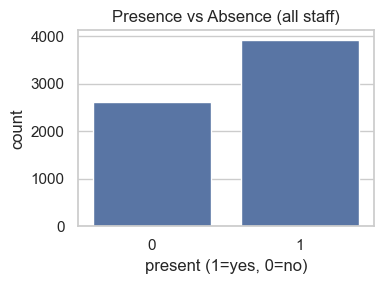

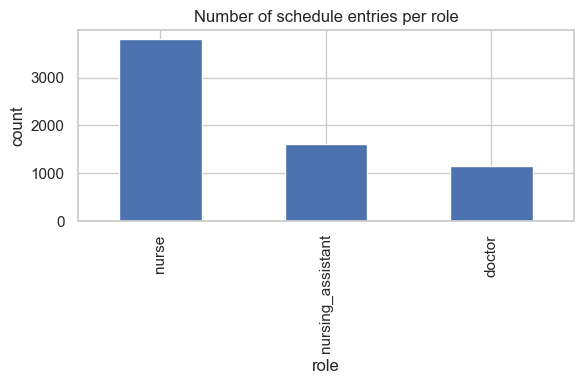

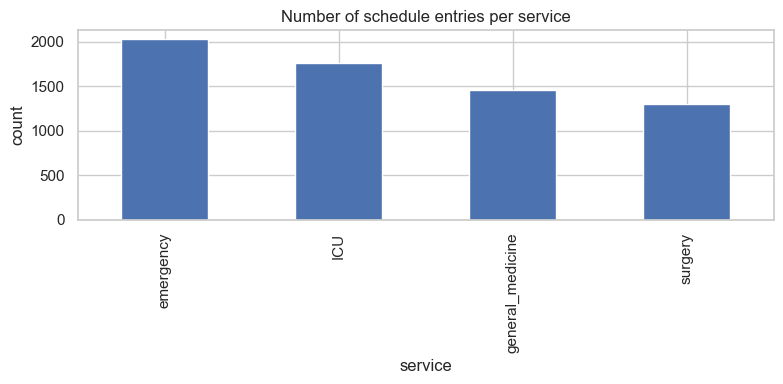


Presence rate by role:
role
nursing_assistant    0.602357
nurse                0.601159
doctor               0.591783
Name: present, dtype: float64


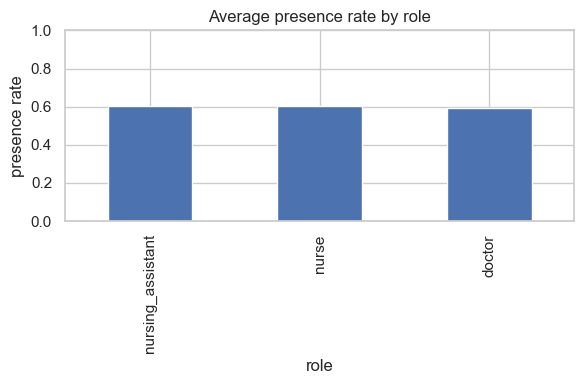


Presence rate by service:
service
emergency           0.604043
surgery             0.602308
ICU                 0.601244
general_medicine    0.589973
Name: present, dtype: float64


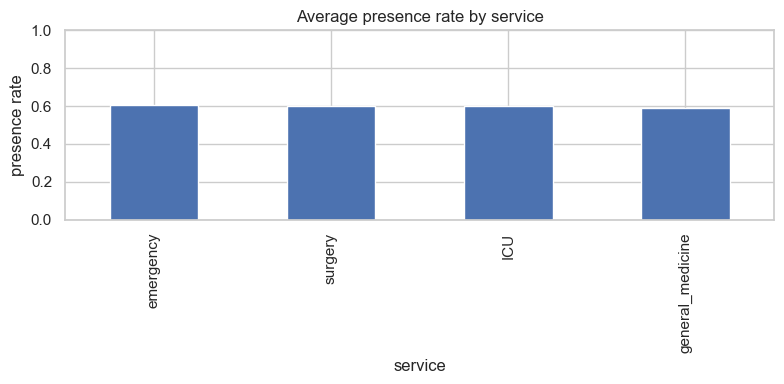

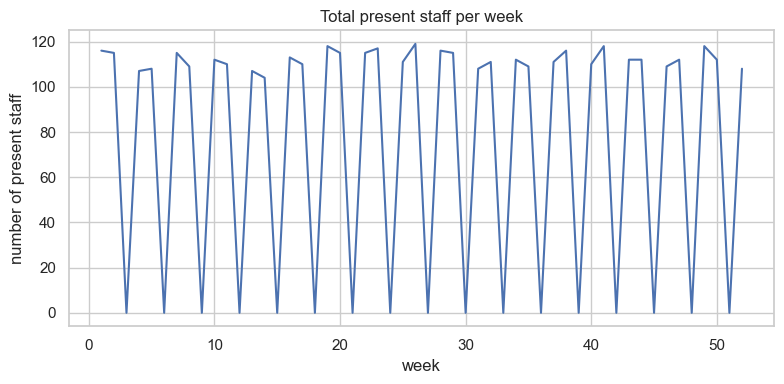

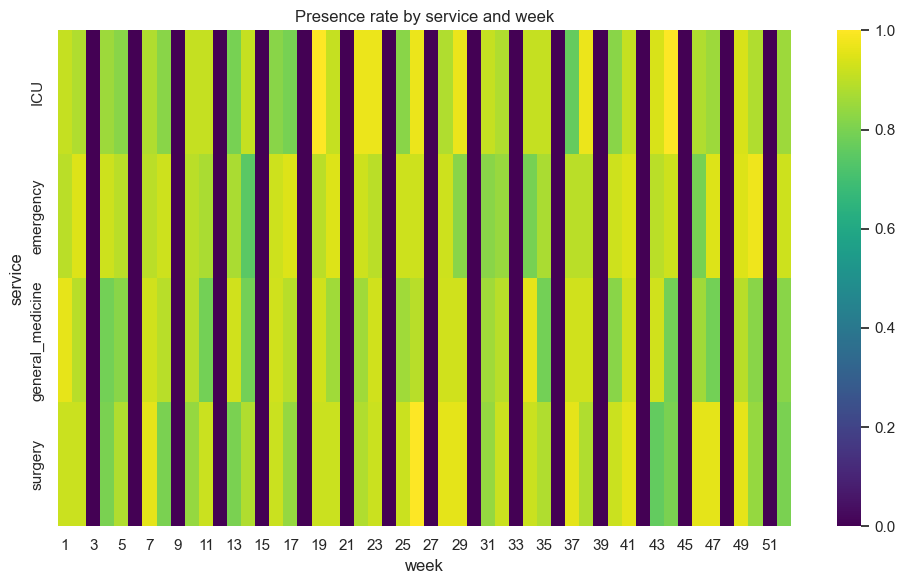

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------------
# 1. Load data
# --------------------------------

file_path = '../../JBI100 Data (2025-2026)/Hospital Beds Management/staff_schedule.csv'
df = pd.read_csv(file_path)

# If needed, rename columns to safe names
df.columns = [c.strip().lower().replace("#", "").replace(" ", "_")
              for c in df.columns]
# Now expect: week, staff_id, staff_name, role, service, present

# --------------------------------
# 2. Quick overview
# --------------------------------
print("Shape:", df.shape)
print("\nHead:")
print(df.head())

print("\nInfo:")
print(df.info())

print("\nSummary of numeric columns:")
print(df.describe())

print("\nMissing values per column:")
print(df.isna().sum())

print("\nUnique values:")
for col in ["week", "staff_id", "staff_name", "role", "service"]:
    print(f"{col}: {df[col].nunique()} uniques")

# --------------------------------
# 3. Basic cleaning checks
# --------------------------------
# Check value distribution of 'present' (0/1 etc.)
print("\nValue counts for 'present':")
print(df["present"].value_counts(dropna=False))

# Optional: ensure correct types
df["week"] = df["week"].astype(int)
df["present"] = df["present"].astype(int)

# --------------------------------
# 4. Univariate distributions
# --------------------------------

sns.set(style="whitegrid")

# a) Presence distribution
plt.figure(figsize=(4,3))
sns.countplot(x="present", data=df)
plt.title("Presence vs Absence (all staff)")
plt.xlabel("present (1=yes, 0=no)")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# b) Staff by role
plt.figure(figsize=(6,4))
df["role"].value_counts().plot(kind="bar")
plt.title("Number of schedule entries per role")
plt.xlabel("role")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# c) Staff by service
plt.figure(figsize=(8,4))
df["service"].value_counts().plot(kind="bar")
plt.title("Number of schedule entries per service")
plt.xlabel("service")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# --------------------------------
# 5. Presence patterns by role / service
# --------------------------------

# Presence rate by role
presence_by_role = df.groupby("role")["present"].mean().sort_values(ascending=False)
print("\nPresence rate by role:")
print(presence_by_role)

plt.figure(figsize=(6,4))
presence_by_role.plot(kind="bar")
plt.title("Average presence rate by role")
plt.xlabel("role")
plt.ylabel("presence rate")
plt.ylim(0,1)
plt.tight_layout()
plt.show()

# Presence rate by service
presence_by_service = df.groupby("service")["present"].mean().sort_values(ascending=False)
print("\nPresence rate by service:")
print(presence_by_service)

plt.figure(figsize=(8,4))
presence_by_service.plot(kind="bar")
plt.title("Average presence rate by service")
plt.xlabel("service")
plt.ylabel("presence rate")
plt.ylim(0,1)
plt.tight_layout()
plt.show()

# --------------------------------
# 6. Weekly patterns
# --------------------------------

# Weekly presence count
weekly_presence = df.groupby("week")["present"].sum()
plt.figure(figsize=(8,4))
weekly_presence.plot()
plt.title("Total present staff per week")
plt.xlabel("week")
plt.ylabel("number of present staff")
plt.tight_layout()
plt.show()

# Weekly presence rate per service (heatmap)
pivot_service_week = (
    df.groupby(["service", "week"])["present"]
      .mean()
      .reset_index()
      .pivot(index="service", columns="week", values="present")
)

plt.figure(figsize=(10,6))
sns.heatmap(pivot_service_week, annot=False, cmap="viridis", vmin=0, vmax=1)
plt.title("Presence rate by service and week")
plt.xlabel("week")
plt.ylabel("service")
plt.tight_layout()
plt.show()


In [10]:
import pandas as pd
import plotly.express as px
from dash import Dash, dcc, html, Input, Output, dash_table
import dash_bootstrap_components as dbc

# ------------------------
# Load and preprocess data
# ------------------------
file_path = '../../JBI100 Data (2025-2026)/Hospital Beds Management/staff_schedule.csv'
df = pd.read_csv(file_path)

df.columns = [c.strip().lower().replace("#", "").replace(" ", "_")
              for c in df.columns]

df["week"] = df["week"].astype(int)
df["present"] = df["present"].astype(int)

# Options
role_options = [{"label": r.title(), "value": r} for r in sorted(df["role"].unique())]
service_options = [{"label": s.title(), "value": s} for s in sorted(df["service"].unique())]
week_min, week_max = int(df["week"].min()), int(df["week"].max())

# ------------------------
# Build App
# ------------------------
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

def card(title, content):
    return dbc.Card(
        [
            dbc.CardHeader(html.H5(title, className="card-title m-0")),
            dbc.CardBody(content)
        ],
        className="shadow-sm"
    )

app.layout = dbc.Container(
    fluid=True,
    children=[

        html.H2("Interactive Staff Schedule Explorer", className="mt-3 mb-4 text-center"),

        dbc.Row(
            [
                dbc.Col(
                    card(
                        "Filters",
                        [
                            html.Label("Filter by Role"),
                            dcc.Dropdown(
                                id="role-filter",
                                options=role_options,
                                value=[r["value"] for r in role_options],
                                multi=True,
                            ),
                            html.Br(),

                            html.Label("Filter by Service"),
                            dcc.Dropdown(
                                id="service-filter",
                                options=service_options,
                                value=[s["value"] for s in service_options],
                                multi=True,
                            ),
                            html.Br(),

                            html.Label("Week Range"),
                            dcc.RangeSlider(
                                id="week-slider",
                                min=week_min,
                                max=week_max,
                                value=[week_min, week_max],
                                marks={w: str(w) for w in range(week_min, week_max + 1)},
                                step=1,
                                allowCross=False,
                            ),
                        ],
                    ),
                    md=3,
                ),

                dbc.Col(
                    card(
                        "Presence Rate Heatmap (Service × Week)",
                        dcc.Graph(id="heatmap", style={"height": "500px"})
                    ),
                    md=9,
                ),
            ],
            className="mb-4",
        ),

        dbc.Row(
            [
                dbc.Col(
                    card(
                        "Presence Counts by Role",
                        dcc.Graph(id="role-bar", style={"height": "350px"})
                    ),
                    md=6,
                ),
                dbc.Col(
                    card(
                        "Presence Counts by Service",
                        dcc.Graph(id="service-bar", style={"height": "350px"})
                    ),
                    md=6,
                ),
            ],
            className="mb-4",
        ),

        card(
            "Clicked Heatmap Cell — Staff Details",
            [
                html.Div(id="heatmap-context", className="mb-2 fw-bold"),
                dash_table.DataTable(
                    id="detail-table",
                    columns=[{"name": i, "id": i} for i in df.columns],
                    page_size=10,
                    style_table={"overflowX": "auto"},
                    style_cell={"textAlign": "left"},
                    style_header={"fontWeight": "bold"},
                ),
            ],
        ),

        html.Br(),
    ],
)

# ------------------------
# Helper
# ------------------------
def filter_df(role_vals, service_vals, week_range):
    dff = df.copy()
    if role_vals:
        dff = dff[dff["role"].isin(role_vals)]
    if service_vals:
        dff = dff[dff["service"].isin(service_vals)]
    if week_range:
        w0, w1 = week_range
        dff = dff[(dff["week"] >= w0) & (dff["week"] <= w1)]
    return dff


# ------------------------
# Callbacks
# ------------------------
@app.callback(
    Output("heatmap", "figure"),
    Output("role-bar", "figure"),
    Output("service-bar", "figure"),
    Input("role-filter", "value"),
    Input("service-filter", "value"),
    Input("week-slider", "value"),
)
def update_main(selected_roles, selected_services, selected_weeks):

    dff = filter_df(selected_roles, selected_services, selected_weeks)

    # ---- Heatmap ----
    heat_df = (
        dff.groupby(["service", "week"])["present"]
        .mean()
        .reset_index()
    )

    if heat_df.empty:
        fig_heat = px.imshow([[0]], text_auto=True)
        fig_heat.update_layout(title="No Data")
    else:
        pivoted = heat_df.pivot(index="service", columns="week", values="present")
        fig_heat = px.imshow(
            pivoted,
            color_continuous_scale="Viridis",
            aspect="auto",
            origin="lower",
        )
        fig_heat.update_layout(
            coloraxis_colorbar_title="Presence Rate",
            margin=dict(l=60, r=20, t=50, b=40),
        )

    # ---- Bar charts ----
    role_counts = (
        dff[dff["present"] == 1]
        .groupby("role")["present"]
        .count()
        .reset_index(name="count")
        .sort_values("count")
    )
    fig_role = px.bar(
        role_counts,
        x="count",
        y="role",
        orientation="h",
        title="Present Staff by Role",
        text="count"
    )

    service_counts = (
        dff[dff["present"] == 1]
        .groupby("service")["present"]
        .count()
        .reset_index(name="count")
        .sort_values("count")
    )
    fig_service = px.bar(
        service_counts,
        x="count",
        y="service",
        orientation="h",
        title="Present Staff by Service",
        text="count"
    )

    # Consistent layout
    for fig in (fig_role, fig_service):
        fig.update_layout(margin=dict(l=20, r=20, t=40, b=20))

    return fig_heat, fig_role, fig_service


# -------- Detail Table --------
@app.callback(
    Output("detail-table", "data"),
    Output("heatmap-context", "children"),
    Input("heatmap", "clickData"),
    Input("role-filter", "value"),
    Input("service-filter", "value"),
    Input("week-slider", "value"),
)
def detail(clickData, roles, services, weeks):

    dff = filter_df(roles, services, weeks)

    if clickData is None:
        return dff.head(10).to_dict("records"), "No cell selected (showing 1st 10 rows)."

    p = clickData["points"][0]
    week = int(p["x"])
    service = p["y"]

    subset = dff[(dff["week"] == week) & (dff["service"] == service)]

    msg = f"Selected: Service = {service}, Week = {week} — {len(subset)} matching rows"

    return subset.to_dict("records"), msg


# ------------------------
# Run
# ------------------------
if __name__ == "__main__":
    app.run(debug=True)
